LSTM try with Data 0

input pressure and saturation on the N_centroid as time series datas

predict pressure and saturation

find the centroid distance  -K means

Combine data into neaty format

In [1]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/pbl-shell/ML-spe1/'

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
from math import sqrt
from random import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from matplotlib import cm

import time

In [3]:
# read the centroids csv
G = pd.read_csv(file_path+'data/G_centroids.csv',  header=None)
G.columns = ['x', 'y', 'z']
# G.head()

# read the rock perm csv
rp = pd.read_csv(file_path+'data/rock_perm.csv',  header=None)
rp.columns = ['rx', 'ry', 'rz']
# rp.head()

G_rp = pd.concat([G, rp], axis=1)
# print(G_rp.shape)
# G_rp.head()

# load the dataset
with open(file_path+'data/df_ps_lst.pkl', 'rb') as f:
    df_ps_lst = pickle.load(f)

In [42]:
# build a function to obtain the lstm model for each cluster
def clustered_lstm(df_Grp, df_ps_lst, clusterby, n_clusters, random_state, test_ratio, n_in, n_out, hyper_dic, 
                   feature, response, plot_cluster, plot_history, plot_result):
################################################################################

    # normalized df_ps_lst first
    df_ps_new = pd.concat(df_ps_lst)
    df_ps_new.columns = ['p', 'sx', 'sy', 'sz']
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_ps_scaled = pd.DataFrame(scaler.fit_transform(df_ps_new))
    df_ps_lst_scaled = []
    for t in range(120):
        df_ps_lst_scaled.append(df_ps_scaled.iloc[:300, :].reset_index(drop=True))
        df_ps_scaled = df_ps_scaled.iloc[300:]
################################################################################

    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), :]
            dataX.append(a)
            dataY.append(dataset[i + look_back, :])
        return np.array(dataX), np.array(dataY)
      
    # convert series to supervised learning
    def series_to_supervised(data, n_in, n_out, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
           cols.append(df.shift(-i))
           if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
           else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
          
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
           agg.dropna(inplace=True)
        return agg

    def get_cube():   
        phi = np.arange(1,10,2)*np.pi/4
        Phi, Theta = np.meshgrid(phi, phi) 

        x = np.cos(Phi)*np.sin(Theta)
        y = np.sin(Phi)*np.sin(Theta)
        z = np.cos(Theta)/100
        return x,y,z

################################################################################
    
    # cluster data
    df_Grp = df_Grp.copy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    if clusterby=='G':
        # cluster by centroid data
        kmeans.fit(df_Grp[['x','y','z']])  
        #learn the labels and the means
        labels = kmeans.predict(df_Grp[['x','y','z']])  
        df_Grp['label'] = labels
    elif clusterby=='rp':
        # cluster by rock perm data
        kmeans.fit(df_Grp[['rx','ry','rz']])  
        #learn the labels and the means
        labels = kmeans.predict(df_Grp[['rx','ry','rz']])  
        df_Grp['label'] = labels
    else:
        # cluster by all
        kmeans.fit(df_Grp)   #data is of shape[300, 3]
        #learn the labels and the means
        labels = kmeans.predict(df_Grp)  
        df_Grp['label'] = labels

    # set index for each centroids
    df_Grp['cell_indx'] = np.arange(0, 300)
    G_c = df_Grp.copy()
    G_c['label_norm'] = MinMaxScaler().fit_transform(np.array(G_c['label']).reshape(-1,1))

    # overall plot setting
    L = 300
    mycolormap = cm.get_cmap('viridis', 300)

    # plot the cluster result
    if plot_cluster == True:
        fig = plt.figure(figsize=(10,10))
        ax = plt.subplot(111, projection='3d')
        for i in G_c.index:
            x,y,z = get_cube()
            # Change the centroid of the cube from zero to values in data frame
            x = x*L + G_c.x[i]
            y = y*L + G_c.y[i]
            z = z*L + G_c.z[i]
            c_idx = G_c.label_norm[i]
            ax.plot_surface(x, y, z, color=mycolormap(c_idx))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.set_title('Cluster Result')            
        plt.show()
    ##############################################################################

    # fix random seed for reproducibility
    tf.random.set_seed(random_state)

    lstm_mod_lst = []
    y_last, yhat_last = [], []
    nrmse_last_lst = []
    total_prediction_time = []

    if hyper_dic==None:
        lstm_nodes = 32
        batch_size = 64
        epoch = 100
    else:
        lstm_nodes = hyper_dic['lstm_nodes']
        batch_size = hyper_dic['batch_size']
        epoch = hyper_dic['epochs']

    if feature=='p' and response=='p':
        feature_col = ['p']
        response_col = ['p_hat']
        true_col = ['p']
        feature_idx = 1
        dense_num = 1
        metric_select= [tf.keras.metrics.CategoricalAccuracy()]
        history_cat = 'categorical_accuracy'
        idx_x = 1; idx_y = 1
    elif feature == 'ps' and response == 'p':
        feature_col = ['p', 'sx', 'sy', 'sz']
        response_col = ['p_hat']
        true_col = ['p']
        feature_idx = 4
        dense_num = 1
        metric_select= [tf.keras.metrics.CategoricalAccuracy()]
        history_cat = 'categorical_accuracy'
        idx_x = 4; idx_y = 1
    elif feature == 's' and response =='s':
        feature_col = ['sx', 'sy', 'sz']
        response_col = ['sx_hat', 'sy_hat', 'sz_hat']
        true_col = ['sx', 'sy', 'sz']
        feature_idx = 3
        dense_num = 3
        metric_select = ['accuracy']
        history_cat = 'accuracy'
        idx_x = 3; idx_y = 3
    elif feature == 'ps' and response =='s':
        feature_col = ['p', 'sx', 'sy', 'sz']
        response_col = ['sx_hat', 'sy_hat', 'sz_hat']
        true_col = ['sx', 'sy', 'sz']
        feature_idx = 4
        dense_num = 3
        metric_select = ['accuracy']
        history_cat = 'accuracy'
        idx_x = 4; idx_y = 3
    else:
        feature_col = ['p', 'sx', 'sy', 'sz']
        response_col = ['p_hat', 'sx_hat', 'sy_hat', 'sz_hat']
        true_col = ['p', 'sx', 'sy', 'sz']
        feature_idx = 4
        dense_num = 4
        metric_select = ['accuracy']
        history_cat = 'accuracy'
        idx_x = 4; idx_y = 4
################################################################################

    # find the last values in each original cell
    y_last_org = []
    for indx in range(300):
        if feature_idx==1:
            last_array_ps = df_ps_lst_scaled[-1].iloc[indx, 0]
                # array_ps_lst shape=120x1
                # rows = the 120th time step
                # columns = p_1
        else:
            last_array_ps = df_ps_lst_scaled[-1].iloc[indx, :].values
            # array_ps_lst shape=120x4
            # rows = the 120th time step
            # columns = p_1, sx_1, sy_1, sz_1 
            last_array_ps = last_array_ps[-feature_idx:]

        # normalize features
        values = last_array_ps.astype('float32')
        y_last_org.append(values)

    df_y_last_org = pd.DataFrame(y_last_org)
    df_y_last_org['cell_indx'] = np.arange(0, 300)
    df_y_last_org['label'] = G_c['label']
################################################################################

    # start lstm
    for label in range(n_clusters):
        
        T = 120
        if feature_idx==1:
            array_ps = np.zeros((T, 1))
            for t in range(T):
                # df_ps_lst[t] shape=300x1
                array_ps[t,:] = df_ps_lst_scaled[t].iloc[df_Grp[df_Grp.label==label].index, 0].mean().reshape((1, -1), order='F')
                # array_ps_lst shape=120x1
                # rows = 120 time steps
                # columns = p_1
        else:
            array_ps = np.zeros((T, 4))
            for t in range(T):
                # df_ps_lst[t] shape=300x4
                array_ps[t,:] = df_ps_lst_scaled[t].iloc[df_Grp[df_Grp.label==label].index, :].mean().values.reshape((1, -1), order='F')
                # array_ps_lst shape=120x4
                # rows = 120 time steps
                # columns = p_1, sx_1, sy_1, sz_1 
            array_ps = array_ps[:, -feature_idx:]

        # normalize features
        values = array_ps.astype('float32')

        # frame as supervised learning
        reframed = series_to_supervised(values, n_in, n_out)      
          
        # split into train and test sets
        values = reframed.values
        last_values = values[-n_in:, :]
        values = values[:-n_in, :]

        train, test = train_test_split(values, test_size=test_ratio, random_state=random_state, shuffle=True) 

        # split into input and outputs
        train_X, train_y = train[:, :-idx_x], train[:, -idx_y:]
        test_X, test_y = test[:, :-idx_x], test[:, -idx_y:]
        last_X, last_y = last_values[:, :-idx_x], last_values[:, -idx_y:]  

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], n_in, -1))
        test_X = test_X.reshape((test_X.shape[0], n_in, -1))
        last_X = last_X.reshape((last_X.shape[0], n_in, -1))

        # design network
        model = Sequential()
        model.add(LSTM(lstm_nodes, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(dense_num))
        model.add(Activation('sigmoid'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
        model.compile(loss='mse', optimizer=optimizer, metrics=metric_select)
        # fit network
        lstm_mod_lst.append(model.fit(train_X, train_y, epochs=int(epoch), 
                            batch_size=batch_size, 
                            validation_data=(test_X, test_y), verbose=0, shuffle=True))
        

        # make a prediction
        yhat = model.predict(test_X)
        # time to predict the last step
        start_time = time.time()
        last_yhat = model.predict(last_X)
        delta_time = time.time() - start_time
        total_prediction_time.append(delta_time)

        # save the last time step
        y_last.append(last_y[-1])
        yhat_last.append(last_yhat[-1])

        # calculate normalized RMSE
        # nrmse = sqrt(mean_squared_error(test_y, yhat))/np.mean(test_y)
        nrmse = sqrt(mean_squared_error(test_y, yhat))

        if label%10==0:
            print('LSTM on cluster ', label)
            # print('Test Normalized RMSE: %.3f' %nrmse)

    print('#####################################################')
    print("Total Prediction Running time: %s seconds" %round(sum(total_prediction_time), 4))
################################################################################
    if plot_history == True:
        if n_clusters<=20:
            # plot history
            fig, ax = plt.subplots(2, n_clusters, figsize=(30, 10), sharex=False, sharey=False)
            for j in range(n_clusters):
                ax[0, j].plot(lstm_mod_lst[j].history['loss'], label='train')
                ax[0, j].plot(lstm_mod_lst[j].history['val_loss'], label='test')
                ax[0, j].set_title('Loss')
                ax[0, j].legend()

                ax[1, j].plot(lstm_mod_lst[j].history[history_cat], label='train')
                ax[1, j].plot(lstm_mod_lst[j].history['val_'+history_cat], label='test')
                ax[1, j].set_title('Accuracy')
                ax[1, j].legend()

            plt.show()
        else:
            # plot history
            fig, ax = plt.subplots(2, 10, figsize=(30, 10), sharex=False, sharey=False)
            idx = int(n_clusters/10)
            for j in range(10):
                ax[0, j].plot(lstm_mod_lst[idx*j].history['loss'], label='train')
                ax[0, j].plot(lstm_mod_lst[idx*j].history['val_loss'], label='test')
                ax[0, j].set_title('Loss')
                ax[0, j].legend()

                ax[1, j].plot(lstm_mod_lst[idx*j].history[history_cat], label='train')
                ax[1, j].plot(lstm_mod_lst[idx*j].history['val_'+history_cat], label='test')
                ax[1, j].set_title('Accuracy')
                ax[1, j].legend()

            plt.show()
################################################################################   

    # construct to original cells
    df_yhat_last = pd.DataFrame(yhat_last)
    df_yhat_last['label'] = np.arange(n_clusters)
    df_result = df_y_last_org.merge(df_yhat_last, how = 'left', on='label').drop(columns='label')
    indx_save = df_result[['cell_indx']]
    df_result = df_result.drop(columns='cell_indx')
    df_result.columns = feature_col + response_col
    df_result['cell_indx'] = indx_save

    # calculate nrmse
    values1 = df_result[true_col].values
    values2 = df_result[response_col].values
    nrmse_last = sqrt(mean_squared_error(values1, values2))
    print('Last Time Step Prediction Normalized RMSE: %.3f' %nrmse_last)
    print('Last Time Step Prediction Accuracy: {:.2%}'.format(1-nrmse_last) )
################################################################################

    if plot_result == True:

        if response == 'p' or response=='ps':
            # plot for the last time pressure
            df_p = df_result[['p', 'p_hat', 'cell_indx']]
            df_p = df_p.merge(G_c, how='right', on='cell_indx')
            fig = plt.figure(figsize=(20,10))
            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')
            for i in df_p.index:
                x,y,z = get_cube()
                # Change the centroid of the cube from zero to values in data frame
                x = x*L + df_p.x[i]
                y = y*L + df_p.y[i]
                z = z*L + df_p.z[i]
                c_idx1 = df_p.p[i]
                c_idx2 = df_p.p_hat[i]
                ax1.plot_surface(x, y, z, color=mycolormap(c_idx1))
                ax2.plot_surface(x, y, z, color=mycolormap(c_idx2))
            ax1.set_xlabel("x")
            ax1.set_ylabel("y")
            ax1.set_zlabel("z")
            ax1.set_title('Original Pressure at the last time step')
            ax2.set_xlabel("x")
            ax2.set_ylabel("y")
            ax2.set_zlabel("z")
            ax2.set_title('Predicted Pressure at the last time step')
            plt.show()

        if response == 's' or response=='ps':
          # plot for the last time sx
            df_sx = df_result[['sx', 'sx_hat', 'cell_indx']]
            df_sx = df_sx.merge(G_c, how='right', on='cell_indx')
            fig = plt.figure(figsize=(20,10))
            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')
            for i in df_sx.index:
                x,y,z = get_cube()
                # Change the centroid of the cube from zero to values in data frame
                x = x*L + df_sx.x[i]
                y = y*L + df_sx.y[i]
                z = z*L + df_sx.z[i]
                c_idx1 = df_sx.sx[i]
                c_idx2 = df_sx.sx_hat[i]
                ax1.plot_surface(x, y, z, color=mycolormap(c_idx1))
                ax2.plot_surface(x, y, z, color=mycolormap(c_idx2))
            ax1.set_xlabel("x")
            ax1.set_ylabel("y")
            ax1.set_zlabel("z")
            ax1.set_title('Original Saturation-X at the last time step')
            ax2.set_xlabel("x")
            ax2.set_ylabel("y")
            ax2.set_zlabel("z")
            ax2.set_title('Predicted Saturation-X at the last time step')
            plt.show()


            # plot for the last time sy
            df_sy = df_result[['sy', 'sy_hat', 'cell_indx']]
            df_sy = df_sy.merge(G_c, how='right', on='cell_indx')
            fig = plt.figure(figsize=(20,10))
            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')
            for i in df_sy.index:
                x,y,z = get_cube()
                # Change the centroid of the cube from zero to values in data frame
                x = x*L + df_sy.x[i]
                y = y*L + df_sy.y[i]
                z = z*L + df_sy.z[i]
                c_idx1 = df_sy.sy[i]
                c_idx2 = df_sy.sy_hat[i]
                ax1.plot_surface(x, y, z, color=mycolormap(c_idx1))
                ax2.plot_surface(x, y, z, color=mycolormap(c_idx2))
            ax1.set_xlabel("x")
            ax1.set_ylabel("y")
            ax1.set_zlabel("z")
            ax1.set_title('Original Saturation-Y at the last time step')
            ax2.set_xlabel("x")
            ax2.set_ylabel("y")
            ax2.set_zlabel("z")
            ax2.set_title('Predicted Saturation-Y at the last time step')
            plt.show()

            # plot for the last time sz
            df_sz = df_result[['sz', 'sz_hat', 'cell_indx']]
            df_sz = df_sz.merge(G_c, how='right', on='cell_indx')
            fig = plt.figure(figsize=(20,10))
            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')
            for i in df_sz.index:
                x,y,z = get_cube()
                # Change the centroid of the cube from zero to values in data frame
                x = x*L + df_sz.x[i]
                y = y*L + df_sz.y[i]
                z = z*L + df_sz.z[i]
                c_idx1 = df_sz.sz[i]
                c_idx2 = df_sz.sz_hat[i]
                ax1.plot_surface(x, y, z, color=mycolormap(c_idx1))
                ax2.plot_surface(x, y, z, color=mycolormap(c_idx2))
            ax1.set_xlabel("x")
            ax1.set_ylabel("y")
            ax1.set_zlabel("z")
            ax1.set_title('Original Saturation-Z at the last time step')
            ax2.set_xlabel("x")
            ax2.set_ylabel("y")
            ax2.set_zlabel("z")
            ax2.set_title('Predicted Saturation-Z at the last time step')
            plt.show()
    

In [10]:
hyper_dic1 = {
    'lstm_nodes':28,
    'batch_size':64, 
    'epochs':100
}

hyper_dic2 = {
    'lstm_nodes':32,
    'batch_size':64, 
    'epochs':100
}

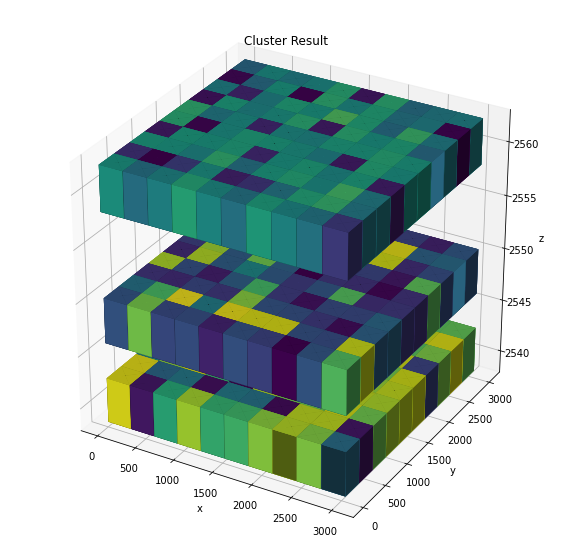

LSTM on cluster  0
LSTM on cluster  10
LSTM on cluster  20
LSTM on cluster  30
LSTM on cluster  40
LSTM on cluster  50
LSTM on cluster  60
LSTM on cluster  70
LSTM on cluster  80
LSTM on cluster  90
LSTM on cluster  100
LSTM on cluster  110
LSTM on cluster  120
LSTM on cluster  130
LSTM on cluster  140
LSTM on cluster  150
LSTM on cluster  160
LSTM on cluster  170
LSTM on cluster  180
LSTM on cluster  190
LSTM on cluster  200
LSTM on cluster  210
LSTM on cluster  220
LSTM on cluster  230
LSTM on cluster  240
LSTM on cluster  250
LSTM on cluster  260
LSTM on cluster  270
LSTM on cluster  280
LSTM on cluster  290
#####################################################
Total Prediction Running time: 18.5819 seconds


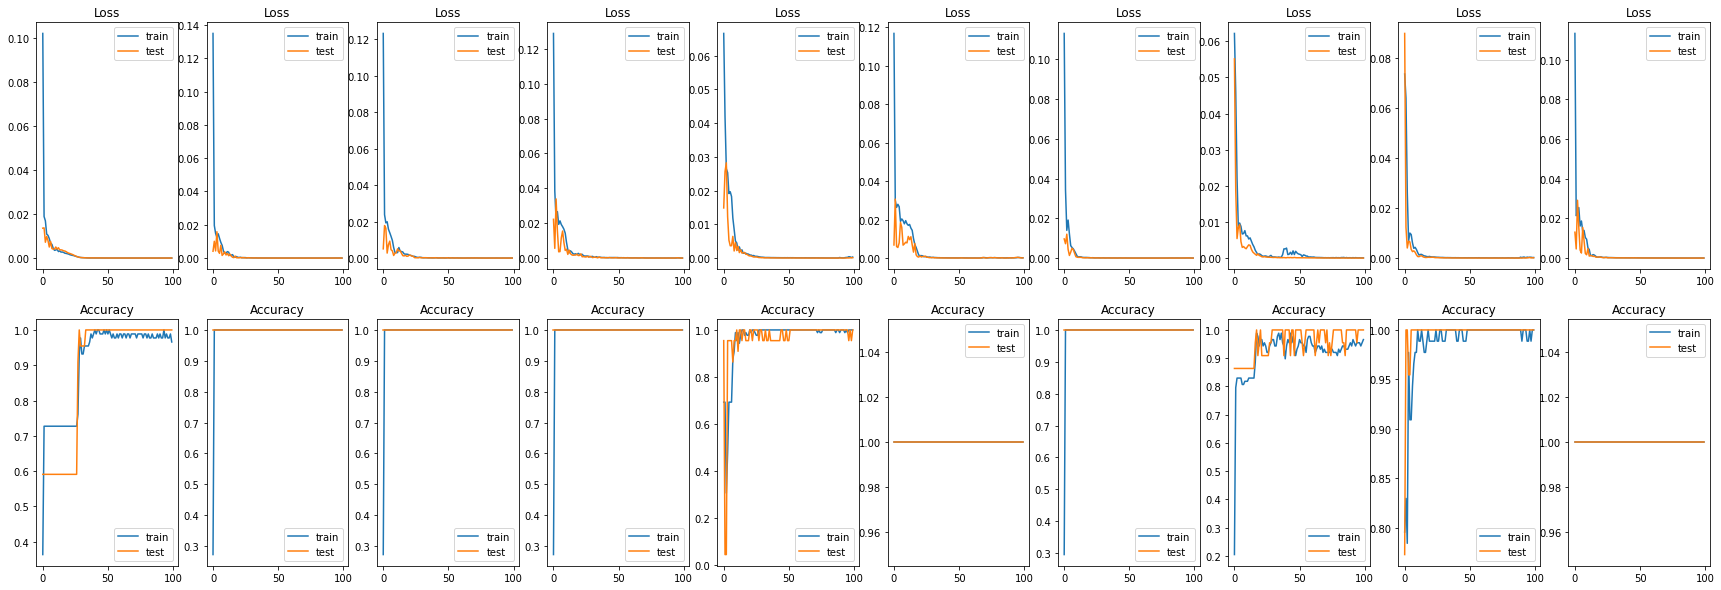

Last Time Step Prediction Normalized RMSE: 0.028
Last Time Step Prediction Accuracy: 97.18%


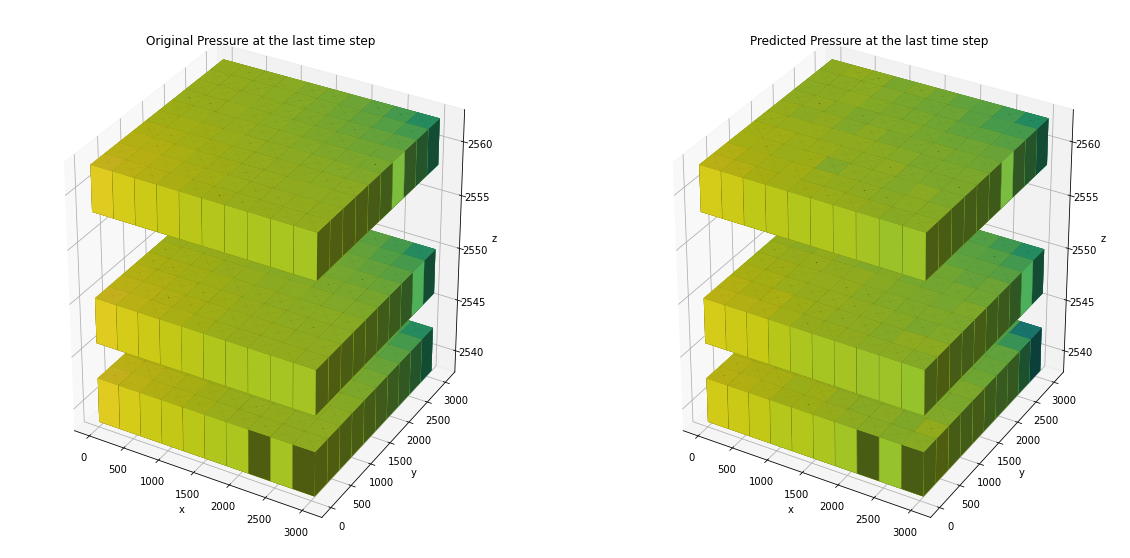

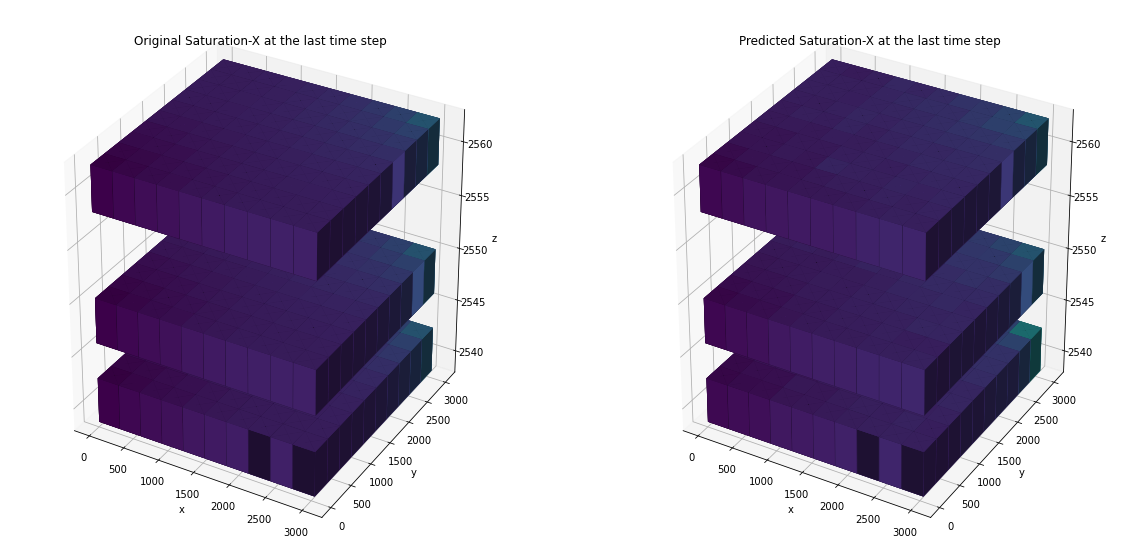

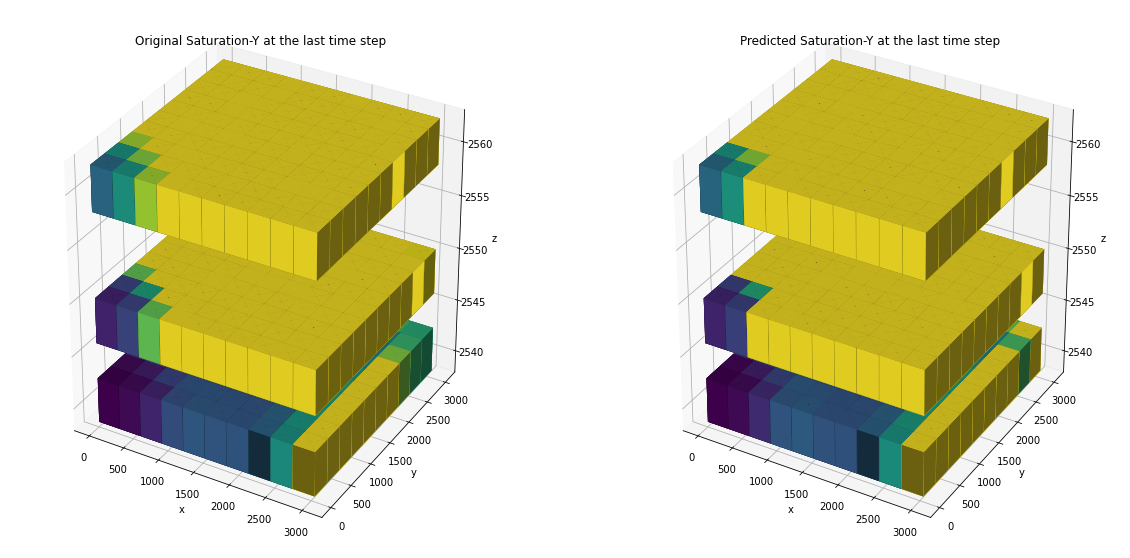

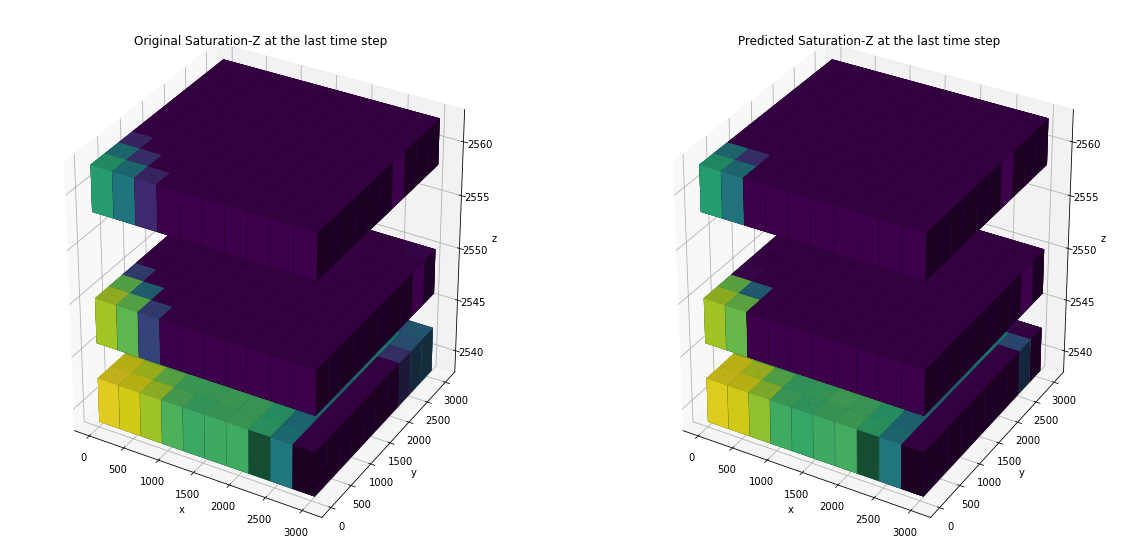

In [22]:
clustered_lstm(df_Grp=G_rp, df_ps_lst = df_ps_lst, clusterby='G', n_clusters=300, random_state=1234, 
               test_ratio=0.2, n_in=5, n_out=1, hyper_dic=hyper_dic1, feature='ps', response='ps', 
               plot_cluster=False, plot_history=True, plot_result=True)

LSTM on cluster  0
LSTM on cluster  10
LSTM on cluster  20
LSTM on cluster  30
LSTM on cluster  40
LSTM on cluster  50
LSTM on cluster  60
LSTM on cluster  70
LSTM on cluster  80
LSTM on cluster  90
LSTM on cluster  100
LSTM on cluster  110
LSTM on cluster  120
LSTM on cluster  130
LSTM on cluster  140
LSTM on cluster  150
LSTM on cluster  160
LSTM on cluster  170
LSTM on cluster  180
LSTM on cluster  190
LSTM on cluster  200
LSTM on cluster  210
LSTM on cluster  220
LSTM on cluster  230
LSTM on cluster  240
#####################################################
Total Prediction Running time: 15.7371 seconds
Last Time Step Prediction Normalized RMSE: 0.120
Last Time Step Prediction Accuracy: 88.01%


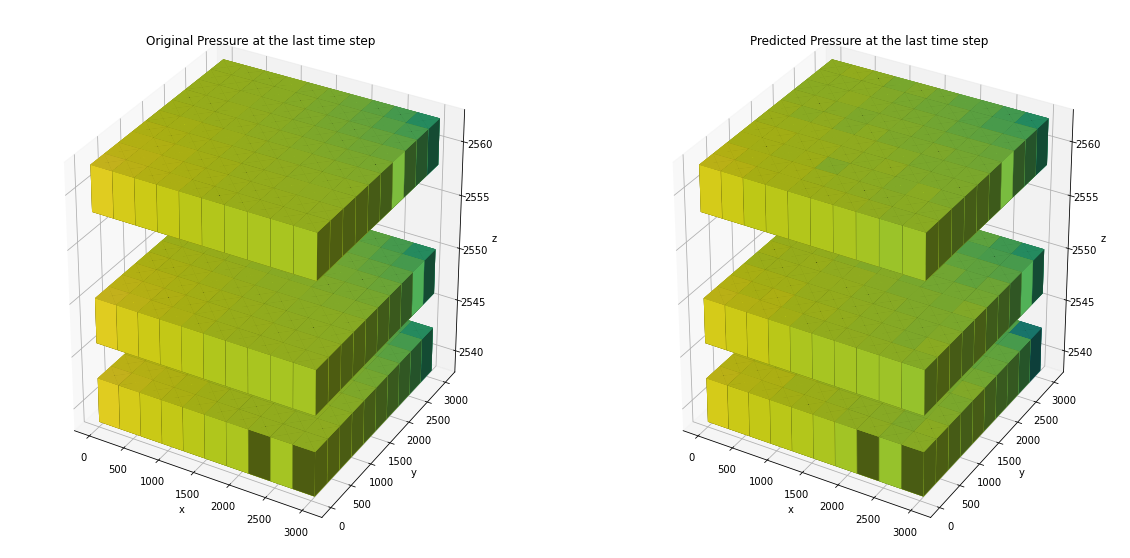

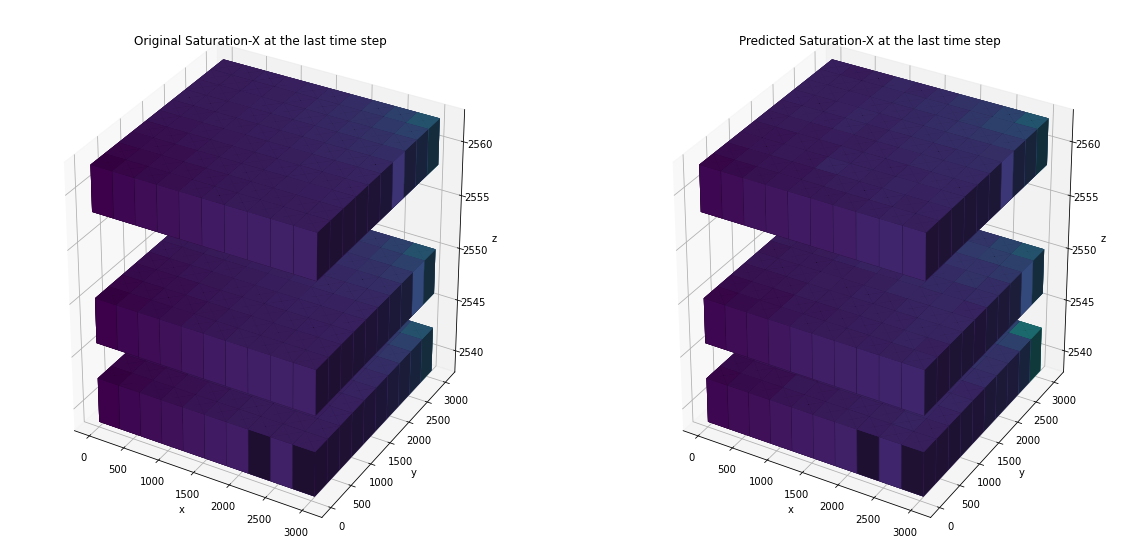

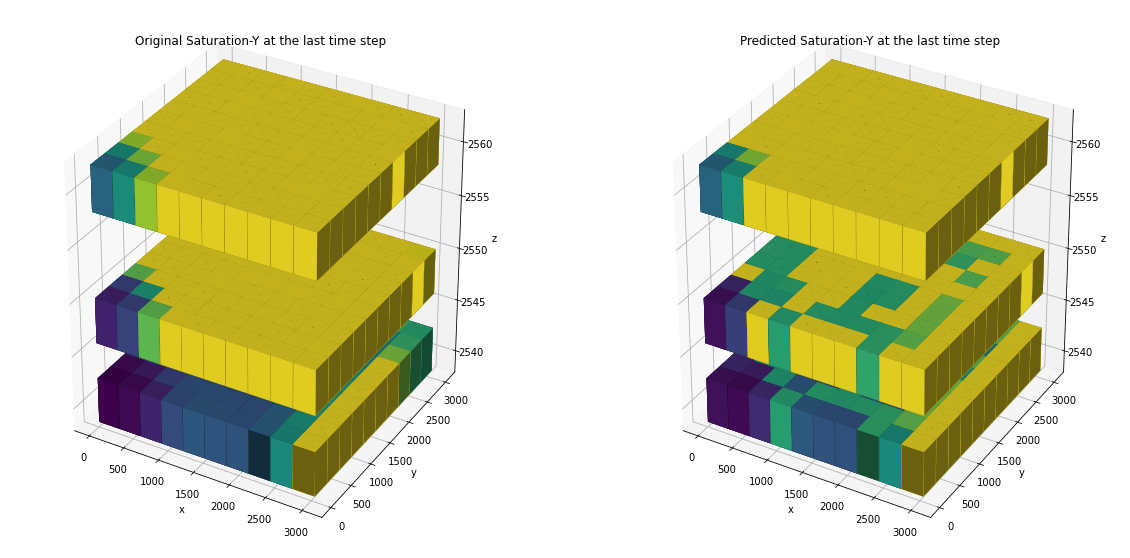

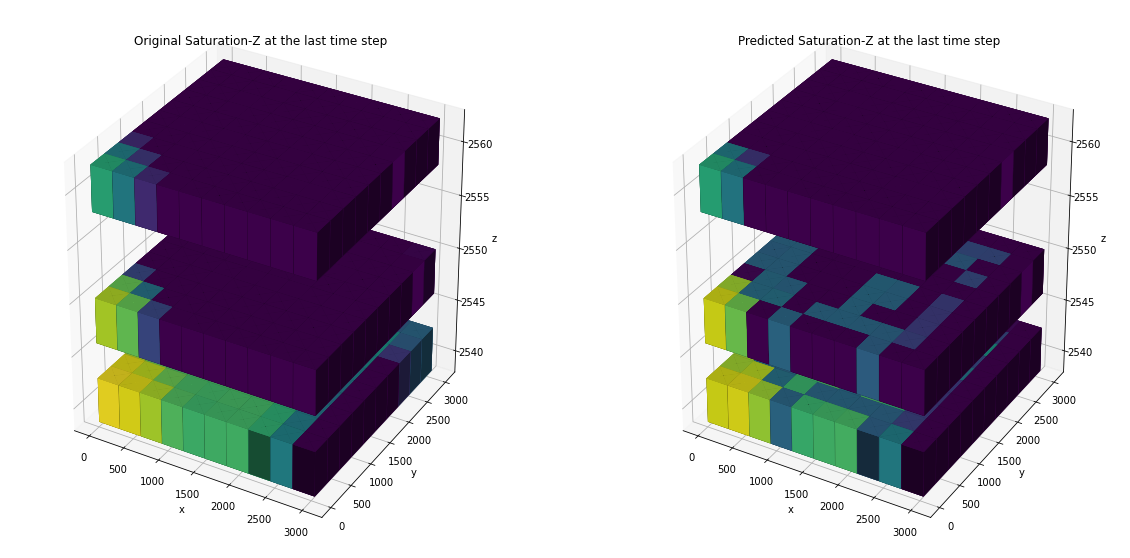

In [47]:
clustered_lstm(df_Grp=G_rp, df_ps_lst = df_ps_lst, clusterby='G', n_clusters=250, random_state=1234, 
               test_ratio=0.2, n_in=5, n_out=1, hyper_dic=hyper_dic1, feature='ps', response='ps', 
               plot_cluster=False, plot_history=False, plot_result=True)

LSTM on cluster  0
LSTM on cluster  10
LSTM on cluster  20
LSTM on cluster  30
LSTM on cluster  40
LSTM on cluster  50
LSTM on cluster  60
LSTM on cluster  70
LSTM on cluster  80
LSTM on cluster  90
LSTM on cluster  100
LSTM on cluster  110
LSTM on cluster  120
LSTM on cluster  130
LSTM on cluster  140
LSTM on cluster  150
LSTM on cluster  160
LSTM on cluster  170
LSTM on cluster  180
LSTM on cluster  190
LSTM on cluster  200
LSTM on cluster  210
LSTM on cluster  220
LSTM on cluster  230
LSTM on cluster  240
#####################################################
Total Prediction Running time: 15.4735 seconds
Last Time Step Prediction Normalized RMSE: 0.135
Last Time Step Prediction Accuracy: 86.45%


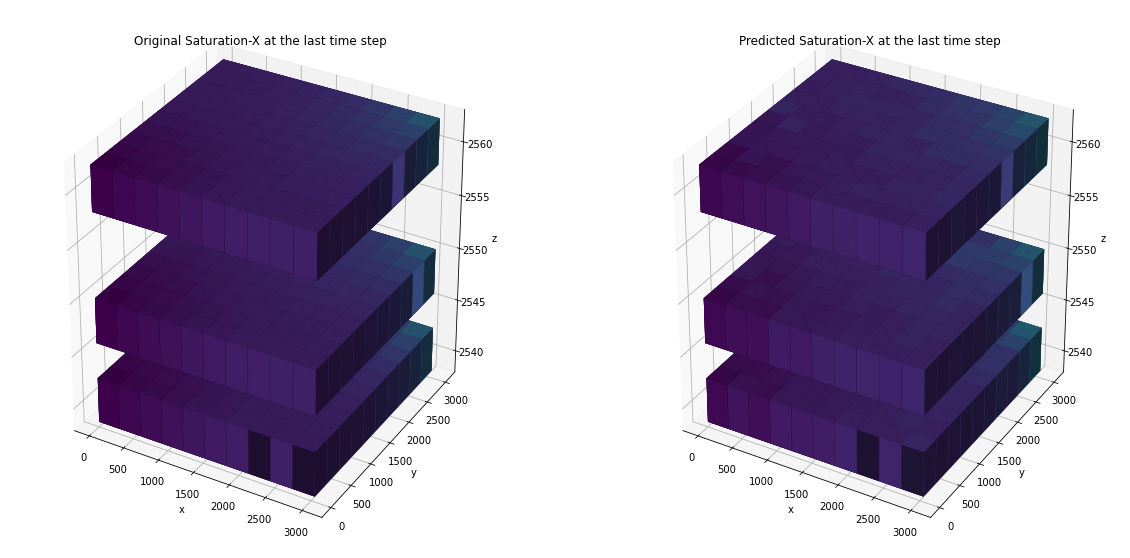

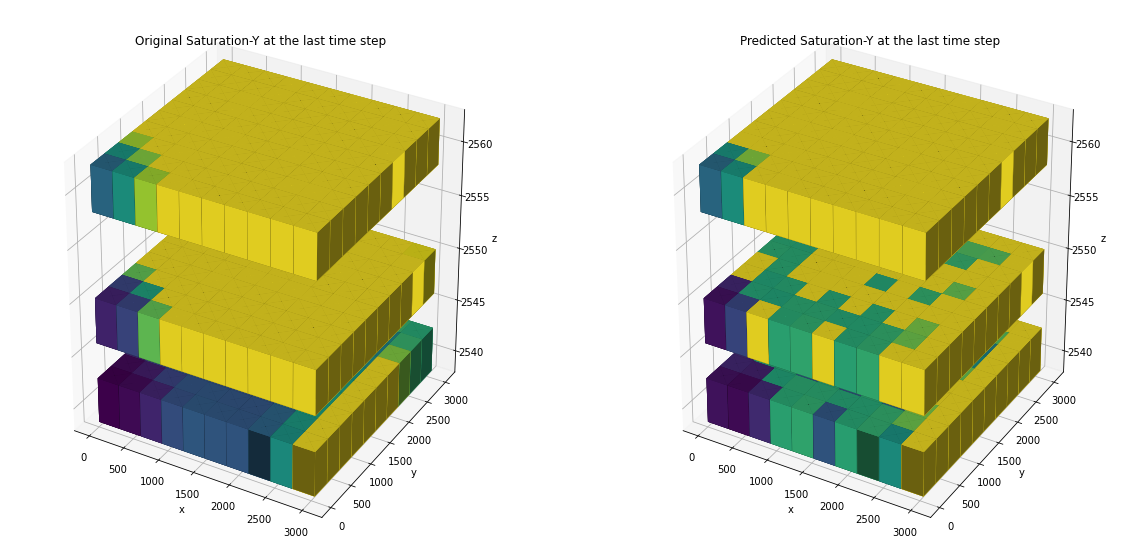

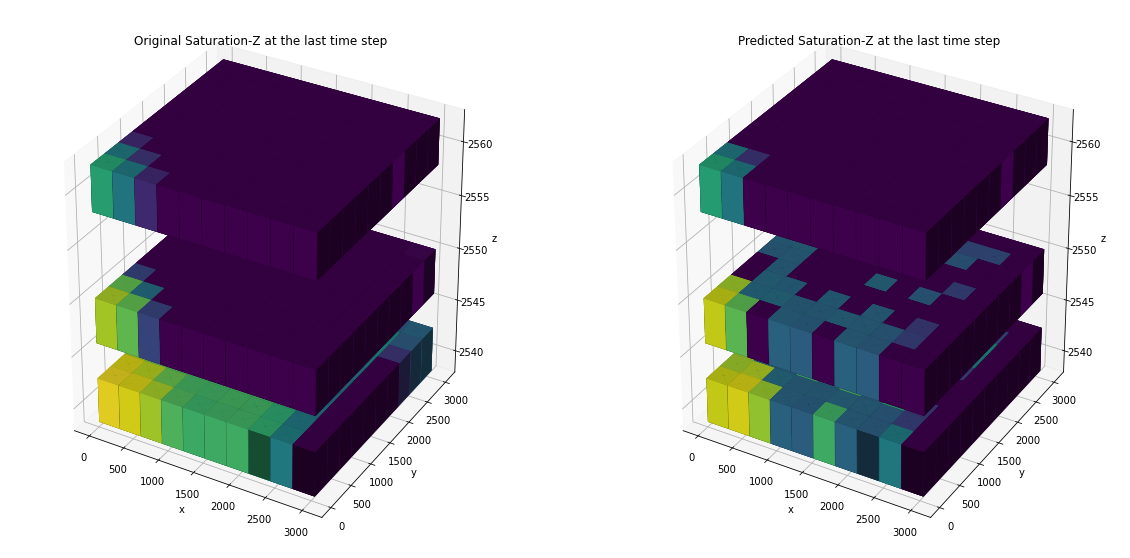

In [46]:
clustered_lstm(df_Grp=G_rp, df_ps_lst = df_ps_lst, clusterby='G', n_clusters=250, random_state=1234, 
               test_ratio=0.2, n_in=5, n_out=1, hyper_dic=hyper_dic1, feature='ps', response='s', 
               plot_cluster=False, plot_history=False, plot_result=True)